## 4.3 实现使用 GELU 激活函数的前馈网络

在本节中，我们将实现一个小型神经网络子模块，该子模块在 LLM 的 Transformer 块中起着重要作用。我们首先实现 GELU 激活函数，这是该神经网络子模块的关键部分。（关于在 PyTorch 中实现神经网络的更多信息，请参见附录 A 中的 A.5 节 "实现多层神经网络"。）

ReLU 激活函数因其简单性和在各种神经网络架构中的有效性，已在深度学习中得到广泛应用。然而，在 LLM 中，除了传统的 ReLU，还有其他几种激活函数被采用。其中，GELU（高斯误差线性单元）和 SwiGLU（Sigmoid-权重线性单元）是两个值得关注的激活函数。

GELU 和 SwiGLU 是更复杂且平滑的激活函数，它们分别使用了高斯和 sigmoid 门控线性单元。与简单的 ReLU 不同，它们能为深度学习模型带来更优秀的性能。

GELU 激活函数可以通过多种方式实现；其精确版本定义为 $GELU(x)=x \Phi(x)$，其中 $\Phi(x)$ 是标准高斯分布的累积分布函数。然而，在实践中，通常会实现一个计算成本更低的近似版本（原始的 GPT-2 模型也是使用这种近似训练的）：


$$GELU(x) \approx 0.5 \cdot x \cdot (1 + \tanh[\sqrt{(2/\pi)} \cdot (x + 0.044715 \cdot x^3)])$$

在代码中，我们可以用如下的 PyTorch 模块实现该功能：

**代码清单 4.3：GELU 激活函数的实现**

In [1]:
import torch
from torch import nn

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

接下来，为了更好地理解 GELU 函数的形状以及它与 ReLU 函数的对比，我们将这两个函数并排绘制出来：

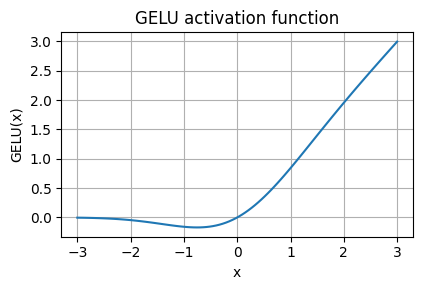

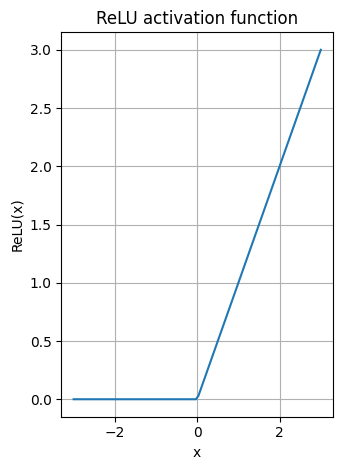

In [3]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100) #A
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

如图 4.8 所示，ReLU 是一个分段线性函数，对于正数输入，它会直接输出该输入值；对于负数输入，它的输出为零。而 GELU 是一个平滑的、非线性函数，它与 ReLU 相似，但在处理负数输入时，其梯度不为零。

**图 4.8 使用 matplotlib 绘制的 GELU 和 ReLU 函数。x 轴代表函数的输入，y 轴代表函数的输出**

![fig4.8](https://github.com/Pr04Ark/llms-from-scratch-cn/blob/trans01/Translated_Book/img/fig-4-8.jpg?raw=true)

如图 4.8 所示，GELU 的平滑性在训练过程中可以带来更优的优化性能，因为它允许对模型参数进行更精细的调整。相较之下，ReLU 在零点处有一个尖角，这有时会使优化变得更为困难，尤其是在网络极其深入或架构复杂的情况下。此外，与 ReLU 对所有负输入都输出零不同，GELU 允许负值有微小的、非零的输出。这一特性意味着在训练过程中，接收到负输入的神经元仍然可以在一定程度上参与学习过程。

接下来，我们将使用 GELU 函数来实现一个小型的神经网络模块 `FeedForward`，这个模块将在后续的 LLM 的 transformer 块中被使用：

**代码清单 4.4 前馈神经网络模块**

In [4]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)

如上述代码所示，`FeedForward` 模块是一个由两个线性层和一个 GELU 激活函数组成的小型神经网络。在拥有 12400 万参数的 GPT 模型中，它接收的输入为 768 维的 Embedding 批量输入，这是由`GPT_CONFIG_124M` 字典中的`GPT_CONFIG_124M["emb_dim"] = 768`配置所决定的 。

图 4.9 展示了当我们向这个小型前馈神经网络输入数据时，Embedding 的维度是如何被处理的。

**图 4.9 前馈神经网络各层之间连接的直观示意图。值得注意的是，该神经网络可以适应不同的批次大小和输入的 token 数量。然而，每个 token 的 Embedding 大小在初始化权重时已经确定并被固定下来。**

![fig4.9](https://github.com/Pr04Ark/llms-from-scratch-cn/blob/trans01/Translated_Book/img/fig-4-9.jpg?raw=true)

如图 4.9 的示例，我们初始化一个 `toke` 的 `Embedding` 大小为 768 的 `FeedForward` 模块，并向其输入一个批次数据，该批次包含 2 个样本，且每个样本含有 3 个 tokens：

In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # 词表大小
    "ctx_len": 1024,      # 上下文长度
    "emb_dim": 768,       # 嵌入维度
    "n_heads": 12,        # 注意力头（attention heads）的数量
    "n_layers": 12,       # 模型层数
    "drop_rate": 0.1,     # Dropout rate
    "qkv_bias": False     # Query-Key-Value bias
}

In [6]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


正如我们所看到的，输出张量的形状与输入张量的形状相同：

```
torch.Size([2, 3, 768])
```

在本节中，我们实现的 `FeedForward` 模块在增强模型从数据中学习和泛化的能力方面发挥了关键作用。虽然该模块的输入和输出维度相同，但它通过第一个线性层将嵌入维度扩展到更高的空间维度，如图 4.10 所示。这个扩展后面跟随的是一个非线性的 GELU 激活函数，然后通过第二个线性变换将其压缩回原始维度。这种设计使模型能够探索更丰富的表示空间。

**图 4.10 展示了前馈神经网络中层输出的扩展和压缩过程。首先，输入维度扩展 4 倍，从 768 维扩展到 3072 维。然后，第二层将这 3072 维压缩回 768 维的表示。**

![fig4.10](https://github.com/Pr04Ark/llms-from-scratch-cn/blob/trans01/Translated_Book/img/fig-4-10.jpg?raw=true)

此外，输入和输出维度的一致性简化了架构设计，使得我们可以堆叠多个层，如我们稍后将要做的，而无需在它们之间调整维度，从而提高了模型的可扩展性。

如图 4.11 所示，我们现在已经实现了构建 LLM 的大部分模块。

**图 4.11 展示了本章我们将要涵盖的主题，其中黑色的勾选标记表示我们已经讨论过的主题。**

![fig4.11](https://github.com/Pr04Ark/llms-from-scratch-cn/blob/trans01/Translated_Book/img/fig-4-11.jpg?raw=true)

在下一节中，我们将探讨在神经网络的不同层之间插入的快捷连接（shortcut connections）的概念，这对于提升深度神经网络架构的训练性能至关重要。